# Predict best library loading concentration
Create a model to determine best library loading concentration.  First a machine learning model is created to predict Cluster Density given a ladder and the library loading concentration. 

Variables Effecting Cluster Density:

Measuring:
1. Bioanalyzer Spectra
2. Library Loading Concentration

Unmeasured:
1. Age of the Kit & flourescence
2. Library Loading concentration onto the Bioanalyzer (Noise due to small volumes)

**TODO:**
2. [] Feature Engineering (Scale independent)
1. [X] Normalization of lower and upper markers
3. [X] Set a Noise Floor With Normalization
4. [X] Fix Scaling Issue on LLC (was multiplied by 100)

In [1]:
import pandas as pd
from IPython.display import display
import os,glob
import numpy as np

#Peak Detection
from scipy.signal import find_peaks_cwt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import peakutils

#Fourier Transforms
from scipy.fftpack import irfft,rfft
from scipy.interpolate import approximate_taylor_polynomial

#Machine Learning
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

test=False

In [2]:
os.listdir('data')

#Get Unique ID Strings
unique_file_ids = []
for file_str in os.listdir('data'):
    if file_str[0] != '.':
        unique_file_ids.append('_'.join(file_str.split('_')[:-1]))
unique_file_ids = list(set(unique_file_ids))
#print(unique_file_ids,len(unique_file_ids))
os.chdir('data')

In [3]:
print(unique_file_ids)
print(len(unique_file_ids))

['NK_SEQ_DEC122017_High Sensitivity DNA Assay_DE24802700_2017-12-12_11-57-18', 'NK_20170802_High Sensitivity DNA Assay_DE24802700_2017-08-02_11-26-52', 'ggoyal_High Sensitivity DNA Assay_DE24802700_2017-07-11_14-23-16', 'ggoyal_High Sensitivity DNA Assay_DE24802700_2017-08-22_12-14-49', 'GG_20170621_High Sensitivity DNA Assay_DE24802700_2017-06-21_14-37-03', 'nk_03_06_2018_High Sensitivity DNA Assay_DE24802700_2018-03-06_15-11-01', 'NK_JLC_NEXTERA1_High Sensitivity DNA Assay_DE24802700_2017-02-02_14-30-54', 'JAM,_JLC_High Sensitivity DNA Assay_DE24802700_2017-09-06_14-50-13', 'Nextera2_jlc_High Sensitivity DNA Assay_DE24802700_2016-09-01_11-31-05', 'NK_20170918_High Sensitivity DNA Assay_DE24802700_2017-09-18_10-28-44', 'nextera_jlc_High Sensitivity DNA Assay_DE24802700_2018-01-10_12-11-58', 'nextera11_jlc_High Sensitivity DNA Assay_DE24802700_2017-07-26_15-45-18', 'ggoyal_High Sensitivity DNA Assay_DE24802700_2017-12-18_11-08-52', 'NK_M_J_M03232017_High Sensitivity DNA Assay_DE2480270

In [4]:
def aproximate_sequence(df,n=100,start=0,stop=15000):
    """Aproximate a discrete sequence using a truncated expansion."""
    
    #Create even spacing
    int_lims = np.linspace(start,stop,n+1)
    
    #Create Interpolation function
    abundance_curve = interp1d(df['base pairs'],df['Value'],fill_value='extrapolate')
    
    #Aproximate Function using an integral
    state = [quad(abundance_curve,a,b)[0] for a,b in zip(int_lims[:-1],int_lims[1:])]
    bps = int_lims[:-1]
    
    return state,bps

def extract_features(df):
    pass
    

def find_peaks(df,test=False):
    """Find the peaks of a ladder gel. Return a list of peak times and the 
    base pairs that correspond to those times.
    """
    
    #display(df)
    peaks = peakutils.indexes(df['Value'].values, thres=0.15, min_dist=10)
    #print(peaks)
    #plt.figure(figsize=(10,10))
    #df['Value'].plot()
    #plt.scatter(peaks,np.zeros(len(peaks)))
    #plt.show()
    peak_bps = [35,50,150,300,400,500,600,700,1000,2000,3000,7000,10380]
    peak_times = df['Time'].values[peaks[1:-1]]
    #print(peak_times)
    
    if test:
        plt.figure()
        df.plot('Time','Value')
        plt.scatter(peak_times,np.zeros(len(peak_times)))
        plt.show()
        print(len(peaks),len(peak_bps))
    
    return peak_times,peak_bps

def normalize_peak(df,start_bp=500,end_bp=11000):
    
    #Subtract out Noise Floor
    noise_floor = np.mean(df['Value'].tail(20))
    df['Value'] -= noise_floor
    df.loc[df['Value']<0,'Value']=0
    
    #Select only important segment
    LIBRARY_SEGMENT = (df['base pairs'] > start_bp) & (df['base pairs'] < end_bp)
    df = df.loc[LIBRARY_SEGMENT]
    
    #Normalize Values to have an area under the curve of 1
    area = np.trapz(df['Value'],x=df['base pairs'])
    df['Value'] /= area
    
    return df

def load_data(file_id):
    """load bioanalyzer data from a set of two csvs. Return a pandas series."""
    
    for file in glob.glob(file_id+'*'):
        #Load Ladder Data
        if 'Ladder' in file:
            ladder_df = pd.read_csv(file,skiprows=17)[:-1]
            ladder_df = ladder_df.apply(np.vectorize(float))
            peak_times,peak_bps = find_peaks(ladder_df,test=test)
            #print(peak_times,peak_bps)
            #print(len(peak_times),len(peak_bps))
            if len(peak_times) != len(peak_bps):
                return None
            
            time_to_bps = interp1d(peak_times,peak_bps,fill_value='extrapolate',kind='slinear')
            
        #Load Sample Data
        elif 'Sample' in file:
            sample_df = pd.read_csv(file,skiprows=17)[:-2]
            sample_df = sample_df.apply(np.vectorize(float))
            sample_df['base pairs'] = sample_df['Time'].apply(time_to_bps)
        
        #plt.scatter(peak_times,peak_bps)
        #plt.plot(np.arange(0,120),np.vectorize(time_to_bps)(np.arange(0,120)))
        #plt.show()
    
    llc = sample_df['Library Loading Concentration (pM)'].values[0]
    cluster_density = sample_df['Cluster Density (K/mm^2)'].values[0]
    sample_df = sample_df.loc[:,sample_df.columns.isin(['Time','Value','base pairs'])]
    
    #Normalize Peak 
    sample_df = normalize_peak(sample_df)
    
    #Plot Base Pairs Vs Values
    #sample_df['logbp'] = np.log10(sample_df['base pairs'])
    #sample_df.plot('base pairs','Value')
    #plt.show()
    
    #sample_df.plot('logbp','Value')
    #plt.show()
    
    #sample_df.plot('Time','Value')
    #plt.show()
    
    #sample_df.plot('Time','base pairs')
    #plt.show()
    
    #display(sample_df)
    state,bps = aproximate_sequence(sample_df,n=10,stop=12000)    
    
    #Create df
    columns = ['Library Loading Concentration','Cluster Density'] + [str(int(bp)) for bp in bps]
    data = [[llc,cluster_density] + state]
    
    state_df = pd.DataFrame(data,columns=columns)
    
    return state_df
    
    
df = None
for file_id in unique_file_ids: 
    #print(file_id)
    state_df = load_data(file_id)
    if state_df is not None:
        if df is None:
            df = state_df
        else:
            df = df.append(state_df)

display(df)
display(df.corr(method='pearson', min_periods=1))


/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/scip

,Library Loading Concentration,Cluster Density,0,1200,2400,3600,4800,6000,7200,8400,9600,10800
0,10.00,1583.0,0.091752,0.141783,0.194913,0.166093,0.142981,0.115309,0.083788,0.063965,0.042090,0.037653
0,10.00,1521.0,0.018949,0.086490,0.155472,0.152426,0.145120,0.136267,0.124040,0.106629,0.067832,0.042507
0,11.50,1703.0,0.079167,0.100278,0.187860,0.164095,0.150228,0.130235,0.099989,0.081804,0.054154,0.033249
0,10.00,1430.0,0.073752,0.131128,0.179011,0.149666,0.124350,0.099274,0.092842,0.108381,0.066979,0.027175
0,10.00,1228.0,0.092701,0.138394,0.195729,0.170054,0.152942,0.130602,0.088610,0.050384,0.030388,0.000416
0,7.75,961.0,0.079543,0.140423,0.171497,0.154136,0.137861,0.109218,0.128022,0.097271,0.021776,0.013122
0,6.70,1393.0,-0.022543,0.239906,0.183538,0.144086,0.084587,0.071981,0.070390,0.066199,0.067948,0.073785
0,10.00,1305.0,-0.032674,0.092251,0.178146,0.164888,0.144460,0.117214,0.095805,0.104262,0.074037,0.008745
0,5.00,1184.0,0.016753,0.190878,0.231661,0.151533,0.106934,0.076687,0.066466,0.068186,0.046679,0.012637
0,10.00,1640.0,0.000459,0.060522,0.145054,0.120621,0.111297,0.133156,0.176370,0.145073,0.097313,0.070266


,Library Loading Concentration,Cluster Density,0,1200,2400,3600,4800,6000,7200,8400,9600,10800
Library Loading Concentration,1.000000,0.531375,0.167781,-0.510461,-0.291263,0.257408,0.507573,0.509613,0.320973,0.105941,0.009589,0.107167
Cluster Density,0.531375,1.000000,0.012334,-0.064492,-0.103087,-0.207155,-0.140223,-0.021476,0.083723,0.242103,0.358930,0.310546
0,0.167781,0.012334,1.000000,0.049442,0.296182,0.228374,0.236181,0.051371,-0.103513,-0.344243,-0.599169,-0.355153
1200,-0.510461,-0.064492,0.049442,1.000000,0.376352,-0.515255,-0.814495,-0.893908,-0.615260,-0.331241,-0.159465,0.029219
2400,-0.291263,-0.103087,0.296182,0.376352,1.000000,0.405475,-0.074479,-0.462884,-0.767070,-0.668879,-0.450068,-0.599624
3600,0.257408,-0.207155,0.228374,-0.515255,0.405475,1.000000,0.816555,0.499751,-0.210149,-0.533159,-0.411179,-0.448031
4800,0.507573,-0.140223,0.236181,-0.814495,-0.074479,0.816555,1.000000,0.866920,0.257066,-0.210673,-0.320192,-0.318689
6000,0.509613,-0.021476,0.051371,-0.893908,-0.462884,0.499751,0.866920,1.000000,0.626957,0.095133,-0.068555,-0.035657
7200,0.320973,0.083723,-0.103513,-0.615260,-0.767070,-0.210149,0.257066,0.626957,1.000000,0.682451,0.177244,0.230152
8400,0.105941,0.242103,-0.344243,-0.331241,-0.668879,-0.533159,-0.210673,0.095133,0.682451,1.000000,0.654992,0.401228


# Fit and Evaluate Machine Learning Models

In [5]:
#Find & Fit Model
X = df.loc[:,df.columns != 'Cluster Density']
y = df['Cluster Density']

#tpot = TPOTRegressor(generations=20, population_size=50, verbosity=2)
#model = tpot.fit(X, y).fitted_pipeline_

#Use a Random Forest Model!
model = RandomForestRegressor().fit(X,y)
feature_df = pd.DataFrame(data=list(zip(list(X.columns),model.feature_importances_)),columns=['Feature','Importance']).set_index('Feature').sort_values('Importance',ascending=False)
display(feature_df)

,Importance
Feature,
10800,0.387928
Library Loading Concentration,0.209253
2400,0.070382
7200,0.064770
8400,0.063255
3600,0.053176
6000,0.041921
4800,0.039533
0,0.034492


In [6]:
#Save out Model
import pickle
with open('../model/model.pkl','wb') as fp:
    pickle.dump(model,fp)

961.0 1703.0 742.0


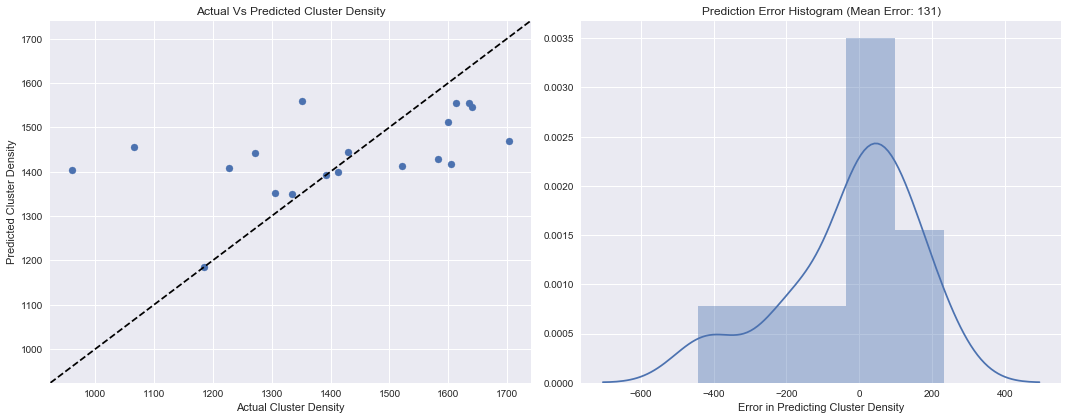

In [7]:
#Plot Cross Validated Predictions
y_p = cross_val_predict(model,X,y)

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.scatter(y,y_p)
axes = plt.gca()
ymin, ymax = axes.get_ylim()
xmin, xmax = axes.get_xlim()
min_val = min(xmin,ymin)
max_val = max(ymax,xmax)
plt.plot([min_val,max_val],[min_val,max_val],'k--')
plt.xlim([min_val,max_val])
plt.ylim([min_val,max_val])
plt.title('Actual Vs Predicted Cluster Density')
plt.xlabel('Actual Cluster Density')
plt.ylabel('Predicted Cluster Density')

plt.subplot(1,2,2)
y_err = [ye -ye_p for ye,ye_p in zip(y,y_p)]
print(min(y),max(y),max(y)-min(y))
sns.distplot(y_err)
plt.title('Prediction Error Histogram (Mean Error: {:0.0f})'.format(np.mean(np.abs(y_err))))
plt.xlabel('Error in Predicting Cluster Density')

plt.tight_layout()
plt.show()



5.0 13.0


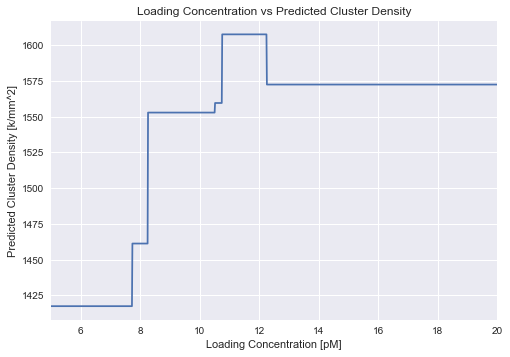

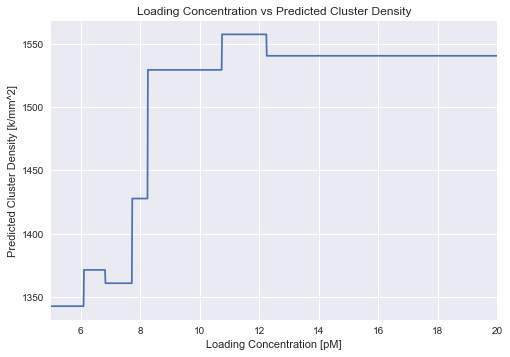

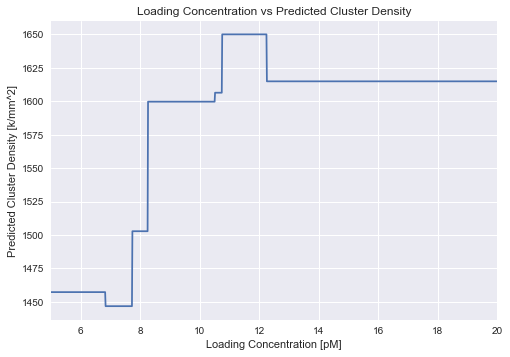

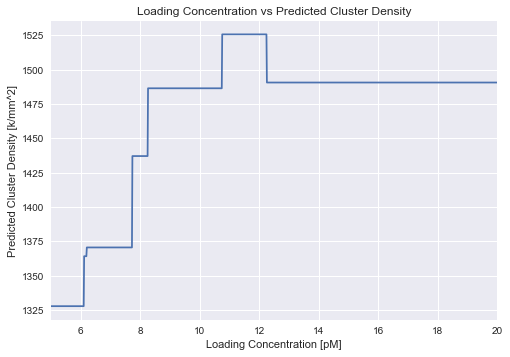

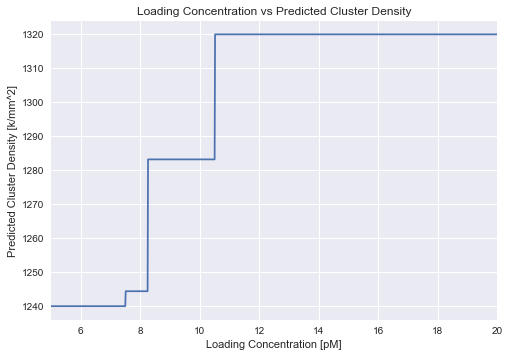

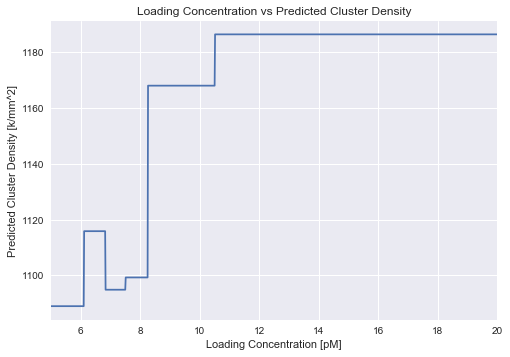

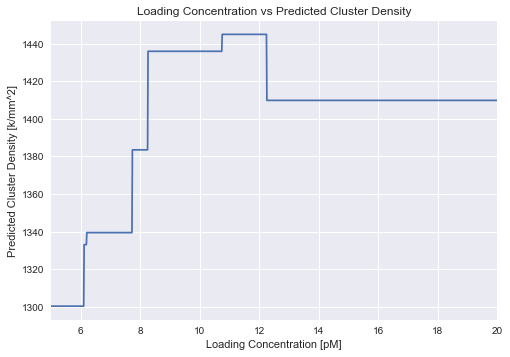

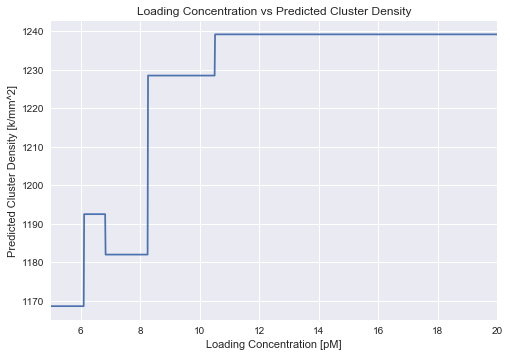

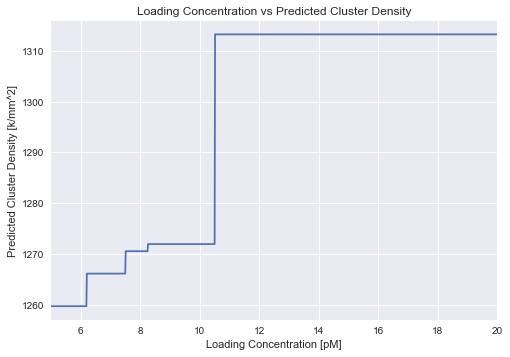

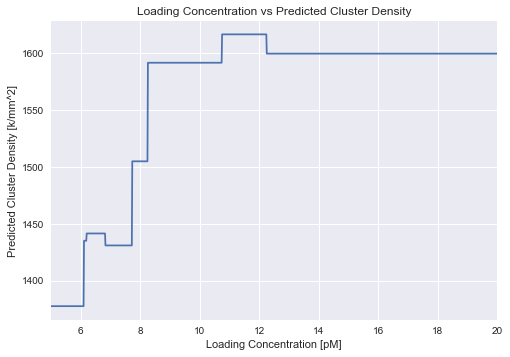

In [8]:
def predict_loading_concentration(spectra,model,low=5,high=20,n=1000):
    cluster_densities = []
    loading_concentrations = np.linspace(low,high,n)
    for lc in loading_concentrations:
        X = np.append(lc,spectra).reshape(1,-1)
        y = model.predict(X)
        cluster_densities.append(y[0])
    
    #print(cluster_densities)
    plt.plot(loading_concentrations,cluster_densities)
    plt.title('Loading Concentration vs Predicted Cluster Density')
    plt.xlabel('Loading Concentration [pM]')
    plt.ylabel('Predicted Cluster Density [k/mm^2]')
    plt.xlim([low,high])
    plt.show()
    
#display(df)

print(min(df['Library Loading Concentration']),max(df['Library Loading Concentration']))
columns = [column for column in df.columns if not column in ['Cluster Density','Library Loading Concentration'] ]
spectra = df[columns].iloc[3].values
#plt.plot(spectra)
#plt.show()

for i in range(10):
    spectra = df[columns].iloc[i].values
    predict_loading_concentration(spectra,model)
